## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_before_actvation(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_after_inputLayer(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch size = %d" % (batch))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch-size-%s" % str(batch)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)     

50000/50000 [==============================] - 41s 810us/step - loss: 1.1176 - acc: 0.6034 - val_loss: 1.3709 - val_acc: 0.5197
Epoch 48/50
50000/50000 [==============================] - 41s 818us/step - loss: 1.1133 - acc: 0.6040 - val_loss: 1.3771 - val_acc: 0.5173
Epoch 49/50
50000/50000 [==============================] - 42s 834us/step - loss: 1.1087 - acc: 0.6082 - val_loss: 1.3818 - val_acc: 0.5202
Epoch 50/50
50000/50000 [==============================] - 41s 816us/step - loss: 1.1018 - acc: 0.6079 - val_loss: 1.3359 - val_acc: 0.5288
Experiment with Batch size = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (B

50000/50000 [==============================] - 23s 452us/step - loss: 0.8283 - acc: 0.7030 - val_loss: 1.5897 - val_acc: 0.5063
Epoch 46/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.8264 - acc: 0.7073 - val_loss: 1.5803 - val_acc: 0.5075
Epoch 47/50
50000/50000 [==============================] - 23s 461us/step - loss: 0.8171 - acc: 0.7081 - val_loss: 1.6256 - val_acc: 0.4865
Epoch 48/50
50000/50000 [==============================] - 23s 455us/step - loss: 0.8042 - acc: 0.7120 - val_loss: 1.5135 - val_acc: 0.5177
Epoch 49/50
50000/50000 [==============================] - 22s 446us/step - loss: 0.7925 - acc: 0.7175 - val_loss: 1.5727 - val_acc: 0.5036
Epoch 50/50
50000/50000 [==============================] - 22s 446us/step - loss: 0.8003 - acc: 0.7145 - val_loss: 1.5694 - val_acc: 0.5103
Experiment with Batch size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1

50000/50000 [==============================] - 5s 105us/step - loss: 0.2760 - acc: 0.9172 - val_loss: 2.1733 - val_acc: 0.4693
Epoch 42/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.2613 - acc: 0.9231 - val_loss: 2.2022 - val_acc: 0.4620
Epoch 43/50
50000/50000 [==============================] - 6s 112us/step - loss: 0.2522 - acc: 0.9249 - val_loss: 2.2393 - val_acc: 0.4673
Epoch 44/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.2366 - acc: 0.9317 - val_loss: 2.3947 - val_acc: 0.4642
Epoch 45/50
50000/50000 [==============================] - 5s 105us/step - loss: 0.2319 - acc: 0.9335 - val_loss: 2.3658 - val_acc: 0.4744
Epoch 46/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.2147 - acc: 0.9400 - val_loss: 2.3063 - val_acc: 0.4814
Epoch 47/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.1976 - acc: 0.9450 - val_loss: 2.4349 - val_acc: 0.4633
Epoch 48/50
50000/50000 [==============

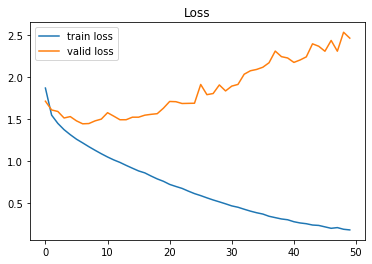

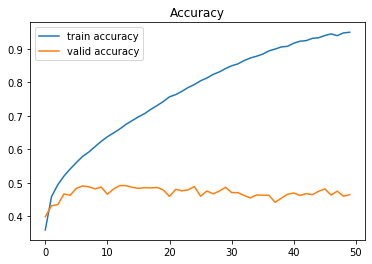

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch size = %d" % (batch))
    model = build_mlp_before_actvation(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch-size-%s" % str(batch)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch size = 2


W0906 08:54:00.398298  6292 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 08:54:00.476299  6292 deprecation.py:323] From D:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

50000/50000 [==============================] - 340s 7ms/step - loss: 2.1935 - acc: 0.1952 - val_loss: 2.2062 - val_acc: 0.2537
Epoch 50/50
50000/50000 [==============================] - 333s 7ms/step - loss: 2.1947 - acc: 0.1929 - val_loss: 2.1622 - val_acc: 0.2459
Experiment with Batch size = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)  

50000/50000 [==============================] - 45s 897us/step - loss: 0.5943 - acc: 0.7887 - val_loss: 1.5485 - val_acc: 0.5457
Epoch 48/50
50000/50000 [==============================] - 47s 941us/step - loss: 0.5721 - acc: 0.7976 - val_loss: 1.5517 - val_acc: 0.5517
Epoch 49/50
50000/50000 [==============================] - 46s 910us/step - loss: 0.5688 - acc: 0.7991 - val_loss: 1.5800 - val_acc: 0.5522
Epoch 50/50
50000/50000 [==============================] - 45s 894us/step - loss: 0.5619 - acc: 0.7982 - val_loss: 1.5654 - val_acc: 0.5537
Experiment with Batch size = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)   

50000/50000 [==============================] - 26s 520us/step - loss: 0.2901 - acc: 0.8970 - val_loss: 2.0515 - val_acc: 0.5380
Epoch 46/50
50000/50000 [==============================] - 24s 488us/step - loss: 0.2868 - acc: 0.8987 - val_loss: 2.0473 - val_acc: 0.5343
Epoch 47/50
50000/50000 [==============================] - 24s 488us/step - loss: 0.2871 - acc: 0.8974 - val_loss: 2.0568 - val_acc: 0.5361
Epoch 48/50
50000/50000 [==============================] - 25s 491us/step - loss: 0.2810 - acc: 0.9013 - val_loss: 2.0680 - val_acc: 0.5410
Epoch 49/50
50000/50000 [==============================] - 25s 491us/step - loss: 0.2665 - acc: 0.9047 - val_loss: 2.1653 - val_acc: 0.5213
Epoch 50/50
50000/50000 [==============================] - 24s 489us/step - loss: 0.2714 - acc: 0.9026 - val_loss: 2.0889 - val_acc: 0.5403
Experiment with Batch size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1

50000/50000 [==============================] - 10s 206us/step - loss: 0.0793 - acc: 0.9768 - val_loss: 2.5444 - val_acc: 0.5209
Epoch 44/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.0774 - acc: 0.9776 - val_loss: 2.5634 - val_acc: 0.5178
Epoch 45/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.0712 - acc: 0.9789 - val_loss: 2.5469 - val_acc: 0.5248
Epoch 46/50
50000/50000 [==============================] - 10s 209us/step - loss: 0.0677 - acc: 0.9806 - val_loss: 2.5731 - val_acc: 0.5232
Epoch 47/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.0637 - acc: 0.9821 - val_loss: 2.6117 - val_acc: 0.5220
Epoch 48/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.0677 - acc: 0.9801 - val_loss: 2.6303 - val_acc: 0.5208
Epoch 49/50
50000/50000 [==============================] - 11s 227us/step - loss: 0.0688 - acc: 0.9795 - val_loss: 2.6588 - val_acc: 0.5213
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 8s 152us/step - loss: 0.0680 - acc: 0.9886 - val_loss: 2.3181 - val_acc: 0.5123
Epoch 42/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.0670 - acc: 0.9883 - val_loss: 2.3555 - val_acc: 0.5067
Epoch 43/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.0641 - acc: 0.9887 - val_loss: 2.3843 - val_acc: 0.5132
Epoch 44/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.0585 - acc: 0.9902 - val_loss: 2.4098 - val_acc: 0.5105
Epoch 45/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.0502 - acc: 0.9927 - val_loss: 2.4250 - val_acc: 0.5105
Epoch 46/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.0481 - acc: 0.9930 - val_loss: 2.4494 - val_acc: 0.5104
Epoch 47/50
50000/50000 [==============================] - 7s 150us/step - loss: 0.0443 - acc: 0.9944 - val_loss: 2.4566 - val_acc: 0.5126
Epoch 48/50
50000/50000 [==============

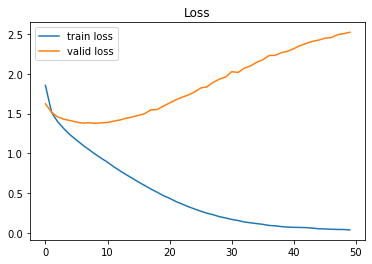

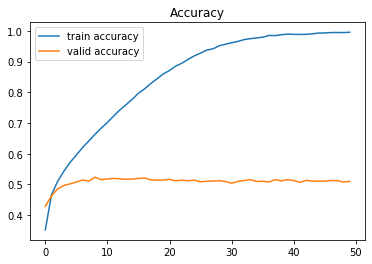

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch size = %d" % (batch))
    model = build_mlp_after_inputLayer(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch-size-%s" % str(batch)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
_______________________________

50000/50000 [==============================] - 388s 8ms/step - loss: 1.9239 - acc: 0.3185 - val_loss: 1.6471 - val_acc: 0.4330
Experiment with Batch size = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)          

Epoch 50/50
50000/50000 [==============================] - 44s 880us/step - loss: 0.3882 - acc: 0.8653 - val_loss: 2.0967 - val_acc: 0.5389
Experiment with Batch size = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 

50000/50000 [==============================] - 24s 477us/step - loss: 0.1963 - acc: 0.9320 - val_loss: 2.6401 - val_acc: 0.5391
Epoch 50/50
50000/50000 [==============================] - 24s 478us/step - loss: 0.1946 - acc: 0.9308 - val_loss: 2.7159 - val_acc: 0.5360
Experiment with Batch size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128

Epoch 49/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.0698 - acc: 0.9786 - val_loss: 3.0476 - val_acc: 0.5146
Epoch 50/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.0734 - acc: 0.9765 - val_loss: 3.0343 - val_acc: 0.5181
Experiment with Batch size = 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)      

50000/50000 [==============================] - 7s 135us/step - loss: 0.0777 - acc: 0.9853 - val_loss: 2.5884 - val_acc: 0.5109
Epoch 50/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.0686 - acc: 0.9877 - val_loss: 2.6463 - val_acc: 0.5093


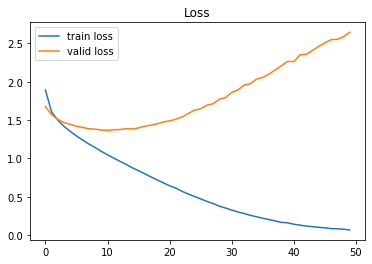

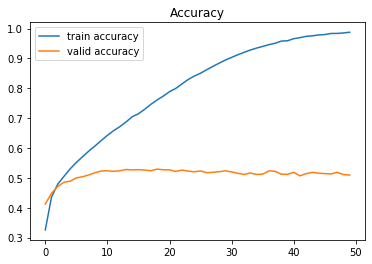

In [14]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()